In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='facebook/opt-350m'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'rank, alpha':[]}

In [4]:
g = 4
lr = 5.0e-5
wd = 0.0
alphas = [8, 16]
ranks = [8, 16]
lora_dropout = 0.0


for a,r in zip(alphas, ranks):
    print(f'Grid search {model_checkpoint}, learning rate {lr} focal loss, gamma: {g} wd: {wd}, Lora alpha {a}, rank {r}')
    data = ClimateDataset(model_to_train=3,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,
                            num_labels=data.num_labels,
                            lora=True,
                            r=r,
                            alpha=a,
                            dropout=lora_dropout)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                          wd=wd,
                          train_dataloader=data.train_dataloader,
                          eval_dataloader=data.eval_dataloader,
                          test_dataloader=data.test_dataloader,
                          accumulation_steps=2,
                          focalloss=True,
                          gamma=g,
                          early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['rank, alpha'].append(r)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search facebook/opt-350m, learning rate 5e-05 focal loss, gamma: 4 wd: 0.0, Lora alpha 8, rank 8


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	9.5652	Val Loss:	2.5739	Accuracy:	0.0799	F1:	0.0741
2 / 30: Train Loss:	6.9520	Val Loss:	2.3961	Accuracy:	0.1154	F1:	0.1181
3 / 30: Train Loss:	6.2630	Val Loss:	2.2844	Accuracy:	0.1538	F1:	0.1559
4 / 30: Train Loss:	6.0927	Val Loss:	2.2598	Accuracy:	0.1598	F1:	0.1689
5 / 30: Train Loss:	5.7675	Val Loss:	2.1357	Accuracy:	0.1598	F1:	0.1626
6 / 30: Train Loss:	5.5729	Val Loss:	2.0403	Accuracy:	0.1982	F1:	0.1999
7 / 30: Train Loss:	5.3402	Val Loss:	1.9969	Accuracy:	0.2160	F1:	0.2162
8 / 30: Train Loss:	5.2898	Val Loss:	1.9879	Accuracy:	0.2189	F1:	0.2175
9 / 30: Train Loss:	4.9501	Val Loss:	1.9613	Accuracy:	0.2249	F1:	0.2408
10 / 30: Train Loss:	4.7822	Val Loss:	1.8795	Accuracy:	0.2781	F1:	0.2699
11 / 30: Train Loss:	4.9861	Val Loss:	2.0496	Accuracy:	0.1686	F1:	0.1819
12 / 30: Train Loss:	5.1704	Val Loss:	1.9993	Accuracy:	0.1923	F1:	0.1895
13 / 30: Train Loss:	6.2513	Val Loss:	2.2371	Accuracy:	0.1065	F1:	0.0911
No improvement for 3 epochs. Stopping early.
best (higgest m

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	9.0370	Val Loss:	2.5585	Accuracy:	0.0680	F1:	0.0638
2 / 30: Train Loss:	6.7533	Val Loss:	2.4099	Accuracy:	0.0888	F1:	0.0911
3 / 30: Train Loss:	6.0739	Val Loss:	2.3000	Accuracy:	0.1331	F1:	0.1403
4 / 30: Train Loss:	5.8463	Val Loss:	2.2480	Accuracy:	0.1391	F1:	0.1541
5 / 30: Train Loss:	5.4936	Val Loss:	2.0828	Accuracy:	0.1805	F1:	0.2004
6 / 30: Train Loss:	5.2242	Val Loss:	1.9422	Accuracy:	0.2633	F1:	0.2529
7 / 30: Train Loss:	4.9517	Val Loss:	1.9307	Accuracy:	0.2189	F1:	0.2134
8 / 30: Train Loss:	5.4330	Val Loss:	2.0134	Accuracy:	0.1864	F1:	0.1946
9 / 30: Train Loss:	5.5399	Val Loss:	2.0362	Accuracy:	0.1538	F1:	0.1499
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                         precision    recall  f1-score   support

             ad hominem       0.67      0.12      0.20        67
               anecdote       0.70      0.49      0.58        43
         cherry picking       0.44      0.21      0.29        56
   

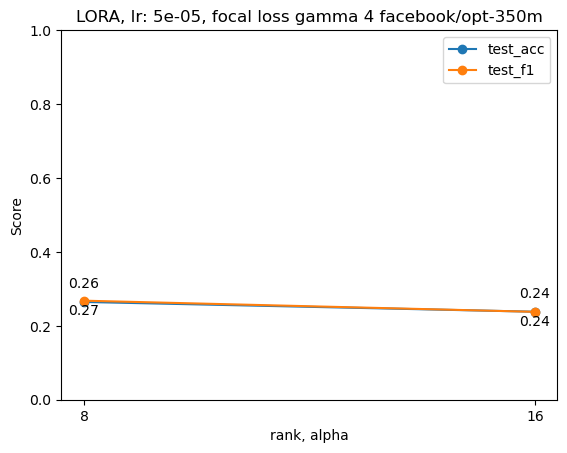

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'LORA, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='rank, alpha',
                        sci_format=False)

In [6]:
%reset -f